In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip


--2024-04-08 00:30:59--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.1.238, 52.216.154.142, 16.182.37.88, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.1.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

100%[======================================>] 13,565,642  7.35MB/s   in 1.8s   

2024-04-08 00:31:01 (7.35 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


## Inspecting the data of the Jena weather dataset - 420451 rows and 15 Features

In [10]:

import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451



## Parsing the data- converting the comma-separated values into floating-point numbers, and then storing specific values in the temperature and raw_data arrays for further processing or analysis.

In [11]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

## Plotting the temperature time series


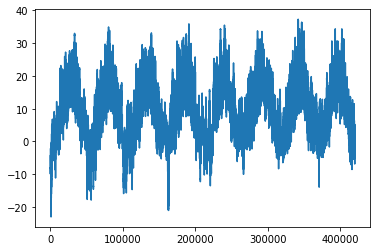

In [4]:

from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

## plotting the first 10 days of the temperature time-series-As given that one day data has 144 data points hence 10 days will have 1440 data points

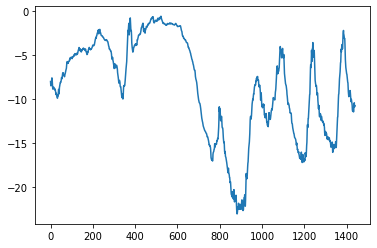

In [5]:

plt.plot(range(1440), temperature[:1440])

## Computing the number of samples we'll use for each data split- 50% for Train, 25%- validation

In [4]:

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


## Preparing the data
## Normalizing the data- Since the data is already in a numerical format, vectorization is unnecessary. However, given that the data scales differ across variables, with temperature ranging from -20 to +30 and pressure measured in millibars, it is advisable to standardize all variables.

In [5]:

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [6]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [7]:

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

## Inspecting the output of one of our datasets

In [9]:
#Inspecting the output of one of our datasets
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


## A common-sense, non-machine-learning baseline
## Computing the common-sense baseline MAE - This defined function "evaluate_naive_method" provides a baseline for evaluating the performance of a simple forecasting approach, where the last value in the input sequence is used as a prediction for the next value.

In [8]:
#A common-sense, non-machine-learning baseline
#Computing the common-sense baseline MAE - This defined function "evaluate_naive_method" provides a baseline for evaluating the performance of a simple forecasting approach, where the last value in the input sequence is used as a prediction for the next value.
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

#A sensible baseline approach would be to forecast that the temperature in the next 24 hours will be the same as it is now. The validation MAE (Mean Absolute Error) using the simple baseline is 2.44 degrees Celsius, while the test MAE is 2.62 degrees Celsius. Put another way, an average deviation of roughly 2.5 degrees would arise from assuming that the future temperature stays constant with the current temperature.

Validation MAE: 2.44
Test MAE: 2.62


In [12]:
#A basic machine-learning model - Dense Layer
#Training and evaluating a densely connected model
#dense layer
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 21s 25ms/step - loss: 11.8920 - mae: 2.6717 - val_loss: 11.4992 - val_mae: 2.6758
Epoch 2/10
819/819 [==============================] - 20s 24ms/step - loss: 8.8204 - mae: 2.3331 - val_loss: 11.6857 - val_mae: 2.7098
Epoch 3/10
819/819 [==============================] - 20s 24ms/step - loss: 8.1253 - mae: 2.2407 - val_loss: 9.8785 - val_mae: 2.4844
Epoch 4/10
819/819 [==============================] - 19s 23ms/step - loss: 7.6863 - mae: 2.1829 - val_loss: 10.3852 - val_mae: 2.5382
Epoch 5/10
819/819 [==============================] - 19s 23ms/step - loss: 7.3907 - mae: 2.1415 - val_loss: 10.4250 - val_mae: 2.5564
Epoch 6/10
819/819 [==============================] - 19s 23ms/step - loss: 7.1638 - mae: 2.1091 - val_loss: 10.4646 - val_mae: 2.5595
Epoch 7/10
819/819 [==============================] - 19s 23ms/step - loss: 6.9606 - mae: 2.0805 - val_loss: 10.5583 - val_mae: 2.5684
Epoch 8/10
819/819 [==============================] - 1

## Plotting results

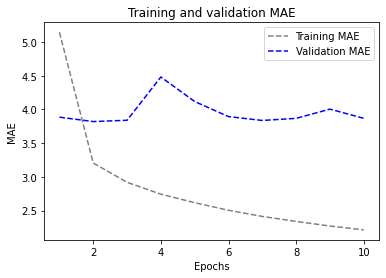

In [19]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


## Let's try a 1D convolutional model

In [13]:
 
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 53s 63ms/step - loss: 22.3347 - mae: 3.7255 - val_loss: 17.9170 - val_mae: 3.3066
Epoch 2/10
819/819 [==============================] - 49s 60ms/step - loss: 15.3041 - mae: 3.1081 - val_loss: 15.9012 - val_mae: 3.1688
Epoch 3/10
819/819 [==============================] - 50s 61ms/step - loss: 13.8827 - mae: 2.9571 - val_loss: 14.7378 - val_mae: 3.0003
Epoch 4/10
819/819 [==============================] - 50s 61ms/step - loss: 13.0386 - mae: 2.8605 - val_loss: 15.9927 - val_mae: 3.1147
Epoch 5/10
819/819 [==============================] - 49s 59ms/step - loss: 12.5290 - mae: 2.8017 - val_loss: 15.4766 - val_mae: 3.1165
Epoch 6/10
819/819 [==============================] - 49s 59ms/step - loss: 12.1198 - mae: 2.7504 - val_loss: 14.0957 - val_mae: 2.9624
Epoch 7/10
819/819 [==============================] - 51s 62ms/step - loss: 11.7629 - mae: 2.7090 - val_loss: 15.5158 - val_mae: 3.0790
Epoch 8/10
819/819 [============================

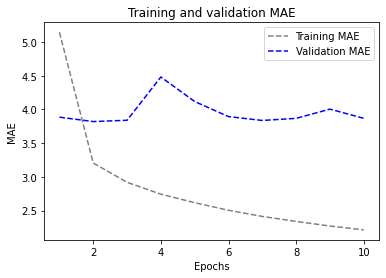

In [20]:

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

#By the above graph, It appears that the convolutional data did not perform as well as the dense model or common sense. This might be the case because

#For meteorological data, the translation invariance assumption is not very strong.

#The data's order is very important. When it comes to forecasting the temperature for the next day, recent historical data is noticeably more useful than data collected several days prior. Sadly, this crucial temporal order is beyond the reach of a 1D convolutional neural network.


## A Simple RNN
## An RNN layer that can process sequences of any length

In [15]:
#Understanding recurrent neural networks
#NumPy implementation of a simple RNN
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

## A recurrent layer in Keras
## An RNN layer that can process sequences of any length

In [16]:


num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [17]:
#simple RNN

num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimpleRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs= 10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimpleRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 51s 61ms/step - loss: 11.7869 - mae: 2.7137 - val_loss: 15.6355 - val_mae: 3.0815
Epoch 2/10
819/819 [==============================] - 48s 58ms/step - loss: 11.4345 - mae: 2.6701 - val_loss: 16.6909 - val_mae: 3.1869
Epoch 3/10
819/819 [==============================] - 47s 57ms/step - loss: 11.0817 - mae: 2.6265 - val_loss: 14.9314 - val_mae: 3.0441
Epoch 4/10
819/819 [==============================] - 48s 59ms/step - loss: 10.8258 - mae: 2.5956 - val_loss: 15.2361 - val_mae: 3.0431
Epoch 5/10
819/819 [==============================] - 49s 60ms/step - loss: 10.5844 - mae: 2.5649 - val_loss: 16.8300 - val_mae: 3.1673
Epoch 6/10
819/819 [==============================] - 48s 59ms/step - loss: 10.3382 - mae: 2.5365 - val_loss: 15.4656 - val_mae: 3.0690
Epoch 7/10
819/819 [==============================] - 47s 57ms/step - loss: 10.1651 - mae: 2.5125 - val_loss: 14.2491 - val_mae: 2.9457
Epoch 8/10
819/819 [============================

## Simple RNN with stacked layer

In [18]:

from tensorflow import keras
from tensorflow.keras import layers
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimpleRNN_stacked.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs= 10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimpleRNN_stacked.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 64s 75ms/step - loss: 136.6376 - mae: 9.5567 - val_loss: 143.3803 - val_mae: 9.8317
Epoch 2/10
819/819 [==============================] - 57s 70ms/step - loss: 135.9526 - mae: 9.5133 - val_loss: 143.3849 - val_mae: 9.8315
Epoch 3/10
819/819 [==============================] - 58s 70ms/step - loss: 135.8954 - mae: 9.5058 - val_loss: 143.4029 - val_mae: 9.8354
Epoch 4/10
819/819 [==============================] - 58s 70ms/step - loss: 135.8727 - mae: 9.5025 - val_loss: 143.3740 - val_mae: 9.8309
Epoch 5/10
819/819 [==============================] - 57s 70ms/step - loss: 135.8513 - mae: 9.4993 - val_loss: 143.4004 - val_mae: 9.8367
Epoch 6/10
819/819 [==============================] - 54s 66ms/step - loss: 135.8455 - mae: 9.4989 - val_loss: 143.3891 - val_mae: 9.8335
Epoch 7/10
819/819 [==============================] - 55s 68ms/step - loss: 135.8398 - mae: 9.4973 - val_loss: 143.3813 - val_mae: 9.8314
Epoch 8/10
819/819 [==============

In [19]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(32, return_sequences=True)(inputs)
x = layers.SimpleRNN(32, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimpleRNN_stacked_1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs= 10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimpleRNN_stacked_1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 80s 95ms/step - loss: 136.3764 - mae: 9.5402 - val_loss: 143.4256 - val_mae: 9.8375
Epoch 2/10
819/819 [==============================] - 74s 90ms/step - loss: 135.9147 - mae: 9.5074 - val_loss: 143.4148 - val_mae: 9.8365
Epoch 3/10
819/819 [==============================] - 76s 92ms/step - loss: 135.8619 - mae: 9.5002 - val_loss: 143.4103 - val_mae: 9.8376
Epoch 4/10
819/819 [==============================] - 73s 89ms/step - loss: 135.8349 - mae: 9.4954 - val_loss: 143.4352 - val_mae: 9.8393
Epoch 5/10
819/819 [==============================] - 71s 87ms/step - loss: 135.8084 - mae: 9.4917 - val_loss: 143.4140 - val_mae: 9.8356
Epoch 6/10
819/819 [==============================] - 73s 89ms/step - loss: 135.8085 - mae: 9.4912 - val_loss: 143.3853 - val_mae: 9.8307
Epoch 7/10
819/819 [==============================] - 70s 86ms/step - loss: 135.7823 - mae: 9.4880 - val_loss: 143.4321 - val_mae: 9.8398
Epoch 8/10
819/819 [==============

In [20]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(32, return_sequences=True)(inputs)
x = layers.SimpleRNN(32, return_sequences=True)(x)
outputs = layers.SimpleRNN(8)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimpleRNN_stacked_2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs= 10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimpleRNN_stacked_2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 76s 91ms/step - loss: 136.3533 - mae: 9.5383 - val_loss: 143.5038 - val_mae: 9.8513
Epoch 2/10
819/819 [==============================] - 66s 80ms/step - loss: 135.8902 - mae: 9.5037 - val_loss: 143.4244 - val_mae: 9.8379
Epoch 3/10
819/819 [==============================] - 69s 84ms/step - loss: 135.8577 - mae: 9.4999 - val_loss: 143.4266 - val_mae: 9.8351
Epoch 4/10
819/819 [==============================] - 68s 83ms/step - loss: 135.8418 - mae: 9.4976 - val_loss: 143.4283 - val_mae: 9.8392
Epoch 5/10
819/819 [==============================] - 69s 84ms/step - loss: 135.8221 - mae: 9.4940 - val_loss: 143.4121 - val_mae: 9.8343
Epoch 6/10
819/819 [==============================] - 67s 82ms/step - loss: 135.7876 - mae: 9.4887 - val_loss: 143.4109 - val_mae: 9.8327
Epoch 7/10
819/819 [==============================] - 66s 81ms/step - loss: 135.7823 - mae: 9.4870 - val_loss: 143.4079 - val_mae: 9.8341
Epoch 8/10
819/819 [==============

## A Simple GRU (Gated Recurrent Unit)

In [15]:
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# GRU layer
x = layers.GRU(16)(inputs)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 56s 66ms/step - loss: 44.0574 - mae: 4.8377 - val_loss: 13.7075 - val_mae: 2.7669
Epoch 2/10
819/819 [==============================] - 56s 68ms/step - loss: 10.8035 - mae: 2.5524 - val_loss: 10.0912 - val_mae: 2.4285
Epoch 3/10
819/819 [==============================] - 55s 68ms/step - loss: 9.6009 - mae: 2.4229 - val_loss: 9.3369 - val_mae: 2.3592
Epoch 4/10
819/819 [==============================] - 54s 66ms/step - loss: 9.2256 - mae: 2.3719 - val_loss: 9.3031 - val_mae: 2.3585
Epoch 5/10
819/819 [==============================] - 53s 65ms/step - loss: 8.9953 - mae: 2.3409 - val_loss: 9.4996 - val_mae: 2.3729
Epoch 6/10
819/819 [==============================] - 56s 68ms/step - loss: 8.7941 - mae: 2.3161 - val_loss: 9.4992 - val_mae: 2.3750
Epoch 7/10
819/819 [==============================] - 55s 67ms/step - loss: 8.6068 - mae: 2.2944 - val_loss: 9.6508 - val_mae: 2.3946
Epoch 8/10
819/819 [==============================] - 55s 

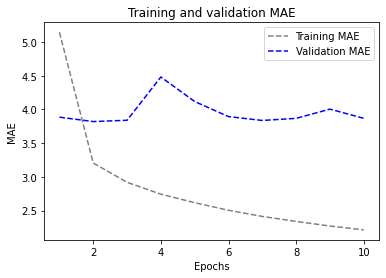

In [22]:

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## LSTM(Long Short-Term Memory )
## 1.LSTM-Simple

In [18]:
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# LSTM layer
x = layers.LSTM(16)(inputs)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 52s 62ms/step - loss: 53.5575 - mae: 5.4207 - val_loss: 15.3609 - val_mae: 2.9379
Epoch 2/10
819/819 [==============================] - 50s 61ms/step - loss: 12.2520 - mae: 2.6945 - val_loss: 9.9958 - val_mae: 2.4705
Epoch 3/10
819/819 [==============================] - 52s 64ms/step - loss: 10.0798 - mae: 2.4826 - val_loss: 9.6223 - val_mae: 2.4166
Epoch 4/10
819/819 [==============================] - 48s 58ms/step - loss: 9.6160 - mae: 2.4203 - val_loss: 10.1660 - val_mae: 2.4727
Epoch 5/10
819/819 [==============================] - 43s 53ms/step - loss: 9.2611 - mae: 2.3698 - val_loss: 9.9701 - val_mae: 2.4661
Epoch 6/10
819/819 [==============================] - 49s 60ms/step - loss: 9.0154 - mae: 2.3374 - val_loss: 10.0488 - val_mae: 2.4679
Epoch 7/10
819/819 [==============================] - 47s 57ms/step - loss: 8.8105 - mae: 2.3090 - val_loss: 10.0916 - val_mae: 2.4830
Epoch 8/10
819/819 [==============================] - 4

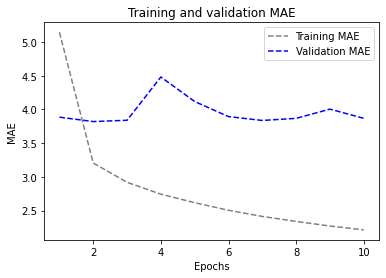

In [23]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## LSTM - Stacked setup with  16 units

In [19]:
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# LSTM layer
x = layers.LSTM(16)(inputs)
#Dropout layer
x = layers.Dropout(0.5)(x)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 51s 61ms/step - loss: 50.5824 - mae: 5.3029 - val_loss: 14.5309 - val_mae: 2.8674
Epoch 2/10
819/819 [==============================] - 50s 61ms/step - loss: 20.2650 - mae: 3.4531 - val_loss: 10.1791 - val_mae: 2.4826
Epoch 3/10
819/819 [==============================] - 48s 59ms/step - loss: 18.2397 - mae: 3.2881 - val_loss: 10.0365 - val_mae: 2.4787
Epoch 4/10
819/819 [==============================] - 50s 60ms/step - loss: 17.1200 - mae: 3.1845 - val_loss: 9.6160 - val_mae: 2.4174
Epoch 5/10
819/819 [==============================] - 50s 61ms/step - loss: 16.5999 - mae: 3.1338 - val_loss: 9.6785 - val_mae: 2.4257
Epoch 6/10
819/819 [==============================] - 49s 60ms/step - loss: 16.0817 - mae: 3.0871 - val_loss: 10.2104 - val_mae: 2.4769
Epoch 7/10
819/819 [==============================] - 49s 59ms/step - loss: 15.6403 - mae: 3.0423 - val_loss: 9.6508 - val_mae: 2.4132
Epoch 8/10
819/819 [==============================]

In [21]:
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# LSTM stacked layer
x = layers.LSTM(16,return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_1.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_lstm_1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 87s 103ms/step - loss: 41.0115 - mae: 4.6601 - val_loss: 13.2070 - val_mae: 2.7580
Epoch 2/10
819/819 [==============================] - 82s 100ms/step - loss: 10.0894 - mae: 2.4553 - val_loss: 9.5193 - val_mae: 2.4088
Epoch 3/10
819/819 [==============================] - 82s 100ms/step - loss: 8.4325 - mae: 2.2695 - val_loss: 10.0712 - val_mae: 2.4788
Epoch 4/10
819/819 [==============================] - 81s 99ms/step - loss: 7.7796 - mae: 2.1822 - val_loss: 9.6844 - val_mae: 2.4282
Epoch 5/10
819/819 [==============================] - 82s 100ms/step - loss: 7.3165 - mae: 2.1135 - val_loss: 9.4801 - val_mae: 2.3989
Epoch 6/10
819/819 [==============================] - 78s 95ms/step - loss: 6.9647 - mae: 2.0602 - val_loss: 10.3597 - val_mae: 2.5161
Epoch 7/10
819/819 [==============================] - 86s 105ms/step - loss: 6.6707 - mae: 2.0154 - val_loss: 10.4651 - val_mae: 2.5246
Epoch 8/10
819/819 [==============================]

## LSTM - Stacked setup with  32 units

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# LSTM layer
x = layers.LSTM(32,return_sequences=True)(inputs)
#LSTM Stacked layer
x = layers.LSTM(32)(x)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_2.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_lstm_2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 122s 145ms/step - loss: 21.7107 - mae: 3.3515 - val_loss: 9.8126 - val_mae: 2.4462
Epoch 2/10
819/819 [==============================] - 116s 142ms/step - loss: 7.9829 - mae: 2.2019 - val_loss: 10.6927 - val_mae: 2.5716
Epoch 3/10
819/819 [==============================] - 117s 143ms/step - loss: 6.3859 - mae: 1.9609 - val_loss: 12.8985 - val_mae: 2.8409
Epoch 4/10
819/819 [==============================] - 117s 142ms/step - loss: 5.3993 - mae: 1.7897 - val_loss: 12.3700 - val_mae: 2.7624
Epoch 5/10
819/819 [==============================] - 117s 142ms/step - loss: 4.6992 - mae: 1.6637 - val_loss: 12.8554 - val_mae: 2.8286
Epoch 6/10
819/819 [==============================] - 115s 140ms/step - loss: 4.1849 - mae: 1.5660 - val_loss: 13.2395 - val_mae: 2.8552
Epoch 7/10
819/819 [==============================] - 116s 142ms/step - loss: 3.6797 - mae: 1.4670 - val_loss: 13.4864 - val_mae: 2.8947
Epoch 8/10
819/819 [=====================

## LSTM - Stacked setup with 8 units

In [13]:
#input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# LSTM layer
x = layers.LSTM(8,return_sequences=True)(inputs)
#LSTM Stacked layer
x = layers.LSTM(8)(x)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_3.keras",
                                    save_best_only=True)
]
# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_lstm_3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 83s 98ms/step - loss: 72.9588 - mae: 6.5763 - val_loss: 37.6746 - val_mae: 4.5908
Epoch 2/10
819/819 [==============================] - 76s 93ms/step - loss: 22.4412 - mae: 3.5019 - val_loss: 13.6763 - val_mae: 2.7844
Epoch 3/10
819/819 [==============================] - 79s 96ms/step - loss: 11.4011 - mae: 2.6108 - val_loss: 9.9695 - val_mae: 2.4497
Epoch 4/10
819/819 [==============================] - 76s 92ms/step - loss: 9.9327 - mae: 2.4527 - val_loss: 9.3796 - val_mae: 2.3790
Epoch 5/10
819/819 [==============================] - 72s 88ms/step - loss: 9.4783 - mae: 2.3974 - val_loss: 9.4128 - val_mae: 2.3992
Epoch 6/10
819/819 [==============================] - 72s 88ms/step - loss: 9.1306 - mae: 2.3563 - val_loss: 9.1994 - val_mae: 2.3665
Epoch 7/10
819/819 [==============================] - 79s 97ms/step - loss: 8.9361 - mae: 2.3297 - val_loss: 9.4793 - val_mae: 2.4054
Epoch 8/10
819/819 [==============================] - 65s

## Lstm with droput stakced layer

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

# input layer
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# stacked layers
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
# output layer
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# callback
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]

# compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# fit the model
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

# evaluate the model
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 83s 98ms/step - loss: 74.9428 - mae: 6.6314 - val_loss: 40.1285 - val_mae: 4.7058
Epoch 2/10
819/819 [==============================] - 79s 97ms/step - loss: 22.9123 - mae: 3.4871 - val_loss: 14.1067 - val_mae: 2.8085
Epoch 3/10
819/819 [==============================] - 73s 89ms/step - loss: 10.8002 - mae: 2.5227 - val_loss: 10.5193 - val_mae: 2.5164
Epoch 4/10
819/819 [==============================] - 70s 85ms/step - loss: 9.2139 - mae: 2.3571 - val_loss: 10.2461 - val_mae: 2.4939
Epoch 5/10
819/819 [==============================] - 79s 96ms/step - loss: 8.8120 - mae: 2.3053 - val_loss: 10.0353 - val_mae: 2.4771
Epoch 6/10
819/819 [==============================] - 72s 87ms/step - loss: 8.5243 - mae: 2.2692 - val_loss: 10.0839 - val_mae: 2.4881
Epoch 7/10
819/819 [==============================] - 74s 90ms/step - loss: 8.2979 - mae: 2.2383 - val_loss: 10.5076 - val_mae: 2.5316
Epoch 8/10
819/819 [==============================] 

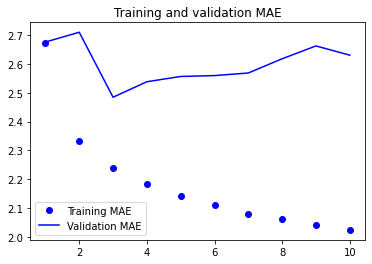

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Lstm Dropout

In [22]:
#lstm droput
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 129s 154ms/step - loss: 28.9737 - mae: 3.9526 - val_loss: 9.5637 - val_mae: 2.3979
Epoch 2/10
819/819 [==============================] - 121s 148ms/step - loss: 14.7776 - mae: 2.9830 - val_loss: 9.1913 - val_mae: 2.3591
Epoch 3/10
819/819 [==============================] - 121s 147ms/step - loss: 14.0724 - mae: 2.9072 - val_loss: 9.4547 - val_mae: 2.3904
Epoch 4/10
819/819 [==============================] - 120s 147ms/step - loss: 13.3624 - mae: 2.8378 - val_loss: 9.5683 - val_mae: 2.3964
Epoch 5/10
819/819 [==============================] - 122s 149ms/step - loss: 12.9013 - mae: 2.7862 - val_loss: 9.4350 - val_mae: 2.3831
Epoch 6/10
819/819 [==============================] - 123s 150ms/step - loss: 12.4678 - mae: 2.7372 - val_loss: 9.1284 - val_mae: 2.3520
Epoch 7/10
819/819 [==============================] - 123s 150ms/step - loss: 12.1330 - mae: 2.7013 - val_loss: 9.5858 - val_mae: 2.4115
Epoch 8/10
819/819 [=====================

In [23]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

## Bidirectional LSTM

In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 95s 113ms/step - loss: 25.7965 - mae: 3.6404 - val_loss: 10.5679 - val_mae: 2.5132
Epoch 2/10
819/819 [==============================] - 88s 108ms/step - loss: 9.4761 - mae: 2.4073 - val_loss: 9.7047 - val_mae: 2.4222
Epoch 3/10
819/819 [==============================] - 88s 107ms/step - loss: 8.6334 - mae: 2.2825 - val_loss: 9.6595 - val_mae: 2.4124
Epoch 4/10
819/819 [==============================] - 87s 106ms/step - loss: 8.1718 - mae: 2.2150 - val_loss: 10.0478 - val_mae: 2.4673
Epoch 5/10
819/819 [==============================] - 90s 110ms/step - loss: 7.7371 - mae: 2.1541 - val_loss: 9.8443 - val_mae: 2.4357
Epoch 6/10
819/819 [==============================] - 93s 113ms/step - loss: 7.4130 - mae: 2.1096 - val_loss: 10.5668 - val_mae: 2.5305
Epoch 7/10
819/819 [==============================] - 85s 104ms/step - loss: 7.1502 - mae: 2.0729 - val_loss: 11.0398 - val_mae: 2.5687
Epoch 8/10
819/819 [==============================

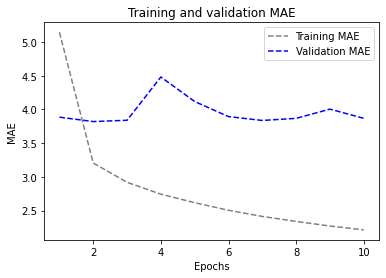

In [24]:

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## 1D Convnets and LSTM togther

In [15]:
#1D convents and LSTM together
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 83s 99ms/step - loss: 47.5336 - mae: 5.1438 - val_loss: 25.1993 - val_mae: 3.8855
Epoch 2/10
819/819 [==============================] - 78s 95ms/step - loss: 17.2939 - mae: 3.2060 - val_loss: 22.8481 - val_mae: 3.8200
Epoch 3/10
819/819 [==============================] - 78s 95ms/step - loss: 14.2558 - mae: 2.9199 - val_loss: 23.0596 - val_mae: 3.8395
Epoch 4/10
819/819 [==============================] - 77s 94ms/step - loss: 12.6434 - mae: 2.7444 - val_loss: 32.6269 - val_mae: 4.4807
Epoch 5/10
819/819 [==============================] - 77s 95ms/step - loss: 11.5385 - mae: 2.6177 - val_loss: 25.6252 - val_mae: 4.1168
Epoch 6/10
819/819 [==============================] - 77s 94ms/step - loss: 10.6282 - mae: 2.5055 - val_loss: 24.4810 - val_mae: 3.8941
Epoch 7/10
819/819 [==============================] - 78s 96ms/step - loss: 9.9065 - mae: 2.4142 - val_loss: 22.6854 - val_mae: 3.8367
Epoch 8/10
819/819 [=============================

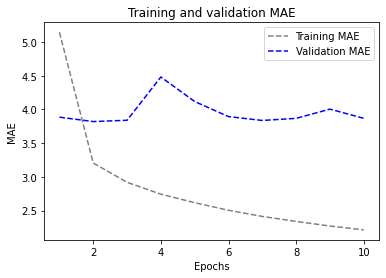

In [16]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

We built 14 models: Following are the details;

Model 1: common-sense, non-machine-learning baseline

Model 2: A basic machine-learning model

Model 3: 1D convolutional model

Model 4: Simple RNN layer that can process sequences of any length

Model 5: Simple RNN - Stacking RNN layers

Model 6: A Simple GRU (Gated Recurrent Unit)

Model 7: LSTM-Simple

Model 8: LSTM - dropout Regularization

Model 9: Stacked setup with 16 units

Model 10: Stacked setup with 32 units

Model 11: Stacked setup with 8 units

Model 12: LSTM - dropout-regularized, stacked

Model 13: Bidirectional LSTM

Model 14: 1D Convnets and LSTM togther

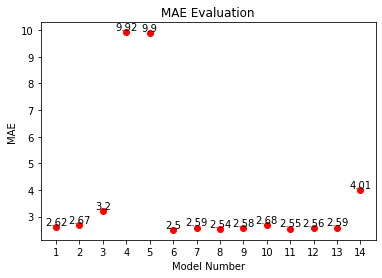

In [17]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.67,3.2,9.92,9.9,2.5,2.59,2.54,2.58,2.68,2.55,2.56,2.59,4.01)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()